In [1]:
import pyrootutils
from pathlib import Path

# Point to your repo root manually
root = pyrootutils.setup_root(
    Path().resolve().parent,  # current working dir
    project_root_env_var=True,
    dotenv=True,
    pythonpath=True,
    cwd=False,
)

In [2]:
import numpy as np
import torch
import pandas as pd
import tqdm
import matplotlib.pyplot as plt
import numpy as np
import cv2
from sklearn.cluster import KMeans
from skimage import filters, morphology, exposure, measure, morphology, segmentation

from src.data_modules.hsi_dermoscopy import HSIDermoscopyDataModule
from src.data_modules.datasets.hsi_dermoscopy_dataset import HSIDermoscopyDataset
from src.models.timm import TIMMModel
from src.metrics.image_precision_recall import ImagePrecisionRecallMetric

/mnt/data/kristhian/miniforge3/envs/hyper/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
def get_hsi_dataset(data_dir: str) -> HSIDermoscopyDataset:
    image_size = 224
    datamodule = HSIDermoscopyDataModule(
        task="classification_melanoma_vs_dysplastic_nevi",
        data_dir=data_dir,
        train_val_test_split=(0.7, 0.15, 0.15),
        batch_size=8,
        allowed_labels=["melanoma"],
        transforms={
            "train": [
                {"class_path": "HorizontalFlip", "init_args": {"p": 0.5}},
                {"class_path": "VerticalFlip", "init_args": {"p": 0.5}},
                {"class_path": "SmallestMaxSize", "init_args": {"max_size": image_size}},
                {"class_path": "CenterCrop", "init_args": {"height": image_size, "width": image_size}},
                {"class_path": "ToTensorV2", "init_args": {}},
            ],
            "val": [
                {"class_path": "SmallestMaxSize", "init_args": {"max_size": image_size}},
                {"class_path": "CenterCrop", "init_args": {"height": image_size, "width": image_size}},
                {"class_path": "ToTensorV2", "init_args": {}},
            ],
            "test": [
                {"class_path": "SmallestMaxSize", "init_args": {"max_size": image_size}},
                {"class_path": "CenterCrop", "init_args": {"height": image_size, "width": image_size}},
                {"class_path": "ToTensorV2", "init_args": {}},
            ],
        },
    )
    datamodule.prepare_data()
    datamodule.setup()
    return datamodule.all_dataloader().dataset

real_dataset = get_hsi_dataset(data_dir="../data/hsi_dermoscopy_croppedv2_256_with_masks")

synth_datasets = {}

synth_datasets["fsgan"] = get_hsi_dataset(data_dir="../data/hsi_dermoscopy_croppedv2_256_synth_fsgan")
synth_datasets["spade_fsgan"] = get_hsi_dataset(data_dir="../data/hsi_dermoscopy_croppedv2_256_synth_spade_fsgan")
synth_datasets["cyclegan"] = get_hsi_dataset(data_dir="../data/hsi_dermoscopy_croppedv2_256_synth_cyclegan")

Dataset already found at ../data/hsi_dermoscopy_croppedv2_256_with_masks
Generating new data splits...
Saved splits to ../data/splits
Generating new data splits...
Saved splits to ../data/splits
Dataset already found at ../data/hsi_dermoscopy_croppedv2_256_synth_fsgan
Generating new data splits...
Saved splits to ../data/splits
Generating new data splits...
Saved splits to ../data/splits
Dataset already found at ../data/hsi_dermoscopy_croppedv2_256_synth_spade_fsgan
Generating new data splits...
Saved splits to ../data/splits
Generating new data splits...
Saved splits to ../data/splits
Dataset already found at ../data/hsi_dermoscopy_croppedv2_256_synth_cyclegan
Generating new data splits...
Saved splits to ../data/splits
Generating new data splits...
Saved splits to ../data/splits


In [4]:
embedding_model = TIMMModel(
    num_classes=0,
    model_name="densenet201",
    in_chans=16,
    pretrained=True,
    features_only=False
)
embedding_model.eval()

# test the model with a random input
dummy_input = torch.randn(1, 16, 224, 224)
dummy_output = embedding_model(dummy_input)
print(f"Dummy output shape: {dummy_output.shape}")

Dummy output shape: torch.Size([1, 1920])


In [5]:
image_prec_rec = ImagePrecisionRecallMetric(feature_extractor=embedding_model, k=3)
image_prec_rec.reset()

# for every synthetic dataset, compute precision and recall.
# compute real features first
real_dataloader = torch.utils.data.DataLoader(real_dataset, batch_size=8, shuffle=False, num_workers=4)
for synth_name, synth_dataset in synth_datasets.items():
    synth_dataloader = torch.utils.data.DataLoader(synth_dataset, batch_size=8, shuffle=False, num_workers=4)
    for batch in real_dataloader:
        images = batch["image"]  # shape (B, C, H, W)
        image_prec_rec.update(images, fake=False)
    for batch in synth_dataloader:
        images = batch["image"]  # shape (B, C, H, W)
        image_prec_rec.update(images, fake=True)
    results = image_prec_rec.compute()
    precision = results["precision"]
    recall = results["recall"]
    print(f"Synthetic dataset: {synth_name} - Precision: {precision:.4f}, Recall: {recall:.4f}")
    image_prec_rec.reset()

Synthetic dataset: fsgan - Precision: 0.8644, Recall: 0.6102
Synthetic dataset: spade_fsgan - Precision: 0.7759, Recall: 0.7241
Synthetic dataset: cyclegan - Precision: 0.6897, Recall: 0.8103


Extracting embeddings:   0%|          | 0/12 [00:00<?, ?it/s]

Extracting embeddings: 100%|██████████| 8/8 [00:02<00:00,  3.59it/s]


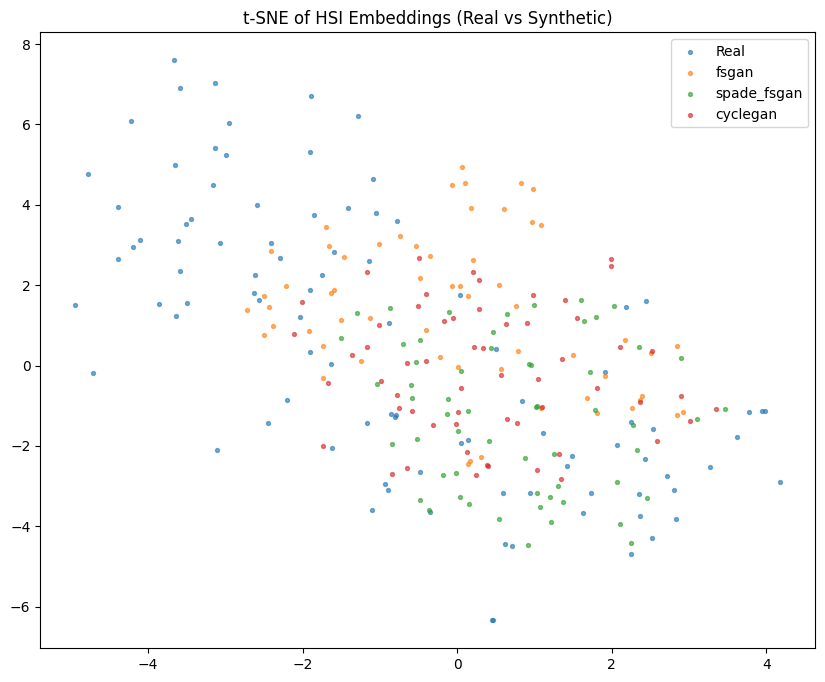

In [6]:
# %%
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import pairwise_distances
from scipy.linalg import sqrtm
from skimage.metrics import structural_similarity as ssim
from math import log10, sqrt
import seaborn as sns
import random

# Helper functions
def extract_embeddings(dataset, model, batch_size=8, num_workers=4):
    dataloader = torch.utils.data.DataLoader(dataset,
                                             batch_size=batch_size,
                                             shuffle=False,
                                             num_workers=num_workers)
    feats = []
    with torch.no_grad():
        for batch in tqdm.tqdm(dataloader, desc="Extracting embeddings"):
            imgs = batch["image"]
            emb = model(imgs).cpu().numpy()
            feats.append(emb)
    return np.concatenate(feats, axis=0)

# %%
# Compute embeddings for real and synthetic datasets
real_feats = extract_embeddings(real_dataset, embedding_model)
synth_feats = {name: extract_embeddings(ds, embedding_model)
               for name, ds in synth_datasets.items()}

# %%
# PCA and t-SNE visualization
pca = PCA(n_components=50, random_state=42)
real_pca = pca.fit_transform(real_feats)
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
real_2d = tsne.fit_transform(real_pca)

tsne_results = {"real": real_2d}
for name, feats in synth_feats.items():
    feats_pca = pca.transform(feats)
    tsne_results[name] = tsne.fit_transform(feats_pca)

plt.figure(figsize=(10, 8))
plt.scatter(tsne_results["real"][:, 0],
            tsne_results["real"][:, 1],
            s=8, label="Real", alpha=0.6)
for name in synth_feats.keys():
    plt.scatter(tsne_results[name][:, 0],
                tsne_results[name][:, 1],
                s=8, label=name, alpha=0.6)
plt.legend()
plt.title("t-SNE of HSI Embeddings (Real vs Synthetic)")
plt.show()

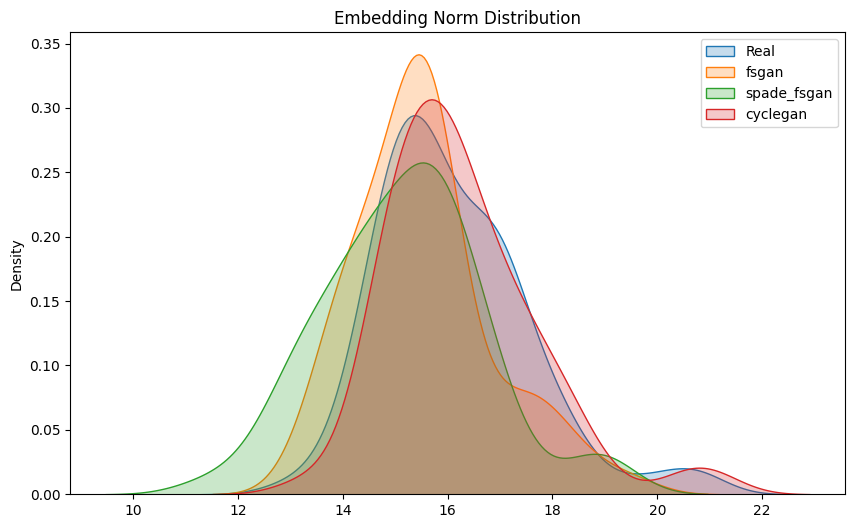

In [7]:
# %%
# Kernel density plots | distribution similarity
plt.figure(figsize=(10, 6))
sns.kdeplot(np.linalg.norm(real_feats, axis=1), label="Real", fill=True)
for name, feats in synth_feats.items():
    sns.kdeplot(np.linalg.norm(feats, axis=1), label=name, fill=True)
plt.legend()
plt.title("Embedding Norm Distribution")
plt.show()

In [8]:
# %%
# Compute Fréchet Distance (FID-like) using model embeddings
def compute_fid(real_feats, synth_feats):
    mu_r, sigma_r = np.mean(real_feats, axis=0), np.cov(real_feats, rowvar=False)
    mu_s, sigma_s = np.mean(synth_feats, axis=0), np.cov(synth_feats, rowvar=False)
    covmean = sqrtm(sigma_r.dot(sigma_s))
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    fid = np.sum((mu_r - mu_s) ** 2) + np.trace(sigma_r + sigma_s - 2 * covmean)
    return fid

for name, feats in synth_feats.items():
    fid_val = compute_fid(real_feats, feats)
    print(f"FID-like distance (Real vs {name}): {fid_val:.4f}")

FID-like distance (Real vs fsgan): 28.7372
FID-like distance (Real vs spade_fsgan): 38.0942
FID-like distance (Real vs cyclegan): 37.1906


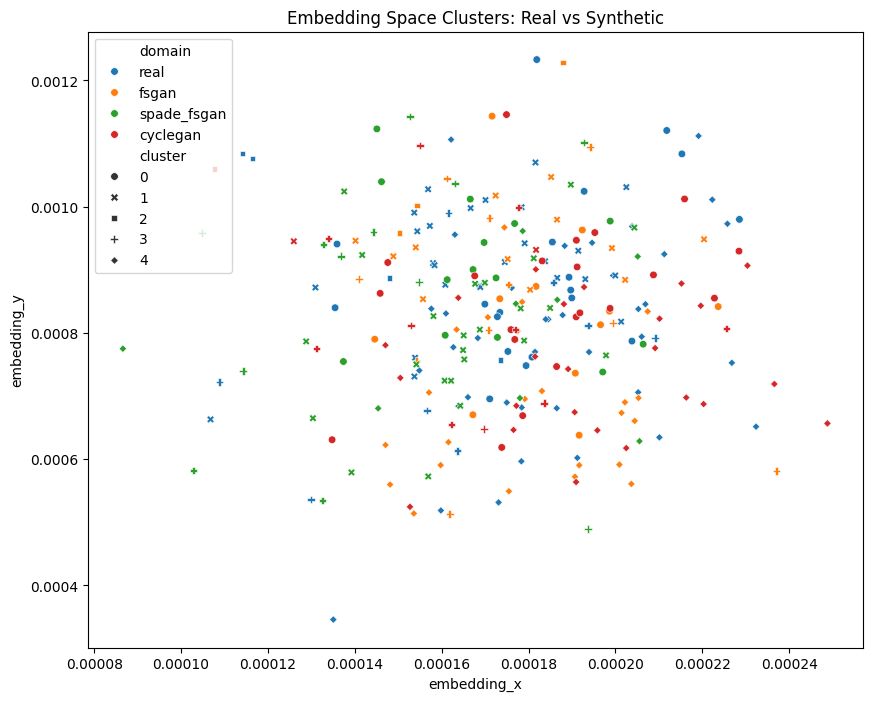

In [9]:
# %%
# Clustering in embedding space
all_feats = np.concatenate([real_feats] + list(synth_feats.values()), axis=0)
labels = (["real"] * len(real_feats)) + sum(
    [[name] * len(feats) for name, feats in synth_feats.items()], []
)
kmeans = KMeans(n_clusters=5, random_state=42).fit(all_feats)
cluster_centers = kmeans.cluster_centers_
cluster_df = pd.DataFrame({
    "embedding_x": all_feats[:, 0],
    "embedding_y": all_feats[:, 1],
    "cluster": kmeans.labels_,
    "domain": labels
})

plt.figure(figsize=(10, 8))
sns.scatterplot(
    data=cluster_df,
    x="embedding_x",
    y="embedding_y",
    hue="domain",
    style="cluster",
    s=30
)
plt.title("Embedding Space Clusters: Real vs Synthetic")
plt.show()

In [10]:
# %%
# Collect all metrics into a summary table

summary_rows = []

# Assume you ran the precision/recall computations earlier.
# We'll reuse their results if available; if not, recompute quickly here.
image_prec_rec.reset()
real_dataloader = torch.utils.data.DataLoader(real_dataset, batch_size=8, shuffle=False, num_workers=4)

def compute_precision_recall_for_dataset(synth_dataset):
    synth_dataloader = torch.utils.data.DataLoader(synth_dataset, batch_size=8, shuffle=False, num_workers=4)
    for batch in real_dataloader:
        image_prec_rec.update(batch["image"], fake=False)
    for batch in synth_dataloader:
        image_prec_rec.update(batch["image"], fake=True)
    result = image_prec_rec.compute()
    image_prec_rec.reset()
    return result["precision"], result["recall"]

metric_table = {}

for name, synth_dataset in synth_datasets.items():
    # Compute precision/recall if not already computed
    precision, recall = compute_precision_recall_for_dataset(synth_dataset)
    fid_val = compute_fid(real_feats, synth_feats[name])

    summary_rows.append({
        "Synthetic Dataset": name,
        "Precision": precision,
        "Recall": recall,
        "FID-like": fid_val,
    })

summary_df = pd.DataFrame(summary_rows)
print("=== Summary of Real vs Synthetic Dataset Metrics ===")
display(summary_df.style.background_gradient(cmap="viridis"))

# %%
# Save to CSV for archival or report generation
output_path = Path("./hsi_similarity_summary.csv")
summary_df.to_csv(output_path, index=False)
print(f"Saved summary CSV to {output_path.resolve()}")

=== Summary of Real vs Synthetic Dataset Metrics ===


,Synthetic Dataset,Precision,Recall,FID-like
0,fsgan,0.864407,0.610169,28.737218
1,spade_fsgan,0.775862,0.724138,38.094241
2,cyclegan,0.689655,0.810345,37.190586


Saved summary CSV to /mnt/data/kristhian/dgm-2025.2/projects/hyperskin/notebooks/hsi_similarity_summary.csv


In [11]:
# %%
from sklearn.metrics import silhouette_score

# --- Helper functions for intra-domain statistics ---

def feature_norm_diff(real_feats, synth_feats):
    """Mean absolute difference in embedding norms."""
    real_norms = np.linalg.norm(real_feats, axis=1)
    synth_norms = np.linalg.norm(synth_feats, axis=1)
    return np.abs(real_norms.mean() - synth_norms.mean())

def feature_variance_ratio(real_feats, synth_feats):
    """Ratio of synthetic embedding variance to real embedding variance."""
    var_real = np.var(real_feats, axis=0).mean()
    var_synth = np.var(synth_feats, axis=0).mean()
    return var_synth / (var_real + 1e-8)

def cluster_purity(real_feats, synth_feats, n_clusters=10):
    """
    Compute cluster purity: how mixed real/synthetic samples are in the same cluster.
    Value closer to 1 = more pure (less domain overlap).
    Lower values mean synthetic and real samples cluster together.
    """
    X = np.concatenate([real_feats, synth_feats], axis=0)
    y_domain = np.array([0] * len(real_feats) + [1] * len(synth_feats))
    km = KMeans(n_clusters=n_clusters, random_state=42).fit(X)
    cluster_labels = km.labels_

    purity_sum = 0
    for c in range(n_clusters):
        idx = cluster_labels == c
        if idx.sum() > 0:
            counts = np.bincount(y_domain[idx])
            purity_sum += np.max(counts)
    return purity_sum / len(X)


# %%
# Extend the summary table with new metrics

extra_stats = []

for row in summary_rows:
    name = row["Synthetic Dataset"]
    feats_synth = synth_feats[name]

    norm_diff = feature_norm_diff(real_feats, feats_synth)
    var_ratio = feature_variance_ratio(real_feats, feats_synth)
    purity = cluster_purity(real_feats, feats_synth, n_clusters=8)

    row.update({
        "Mean Feature Norm Δ": norm_diff,
        "Variance Ratio (Synth/Real)": var_ratio,
        "Cluster Purity": purity
    })
    extra_stats.append(row)

summary_df = pd.DataFrame(extra_stats)

# Nicely formatted summary display
print("=== Comprehensive Summary of Real vs Synthetic Dataset Metrics ===")
display(
    summary_df.style
    .background_gradient(cmap="viridis", subset=["Precision", "Recall", "FID-like"])
    .format({
        "Precision": "{:.3f}",
        "Recall": "{:.3f}",
        "FID-like": "{:.2f}",
        "Mean Feature Norm Δ": "{:.3f}",
        "Variance Ratio (Synth/Real)": "{:.3f}",
        "Cluster Purity": "{:.3f}",
    })
)

# %%
# Save updated version to CSV
output_path = Path("./hsi_similarity_summary_extended.csv")
summary_df.to_csv(output_path, index=False)
print(f"Saved extended intra-domain summary CSV to {output_path.resolve()}")

=== Comprehensive Summary of Real vs Synthetic Dataset Metrics ===


,Synthetic Dataset,Precision,Recall,FID-like,Mean Feature Norm Δ,Variance Ratio (Synth/Real),Cluster Purity
0,fsgan,0.864,0.610,28.74,0.567,0.892,0.669
1,spade_fsgan,0.776,0.724,38.09,0.942,0.848,0.719
2,cyclegan,0.690,0.810,37.19,0.153,0.997,0.667


Saved extended intra-domain summary CSV to /mnt/data/kristhian/dgm-2025.2/projects/hyperskin/notebooks/hsi_similarity_summary_extended.csv
